In [1]:
import gurobipy as gp
import numpy as np
from gurobipy import GRB 
import networkx as nx
import matplotlib.pyplot as plt
import random
import matplotlib.colors as mcolors
plt.rcParams['figure.dpi'] = 150

# Defining the model object
model = gp.Model("DFG")
report = True

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-08


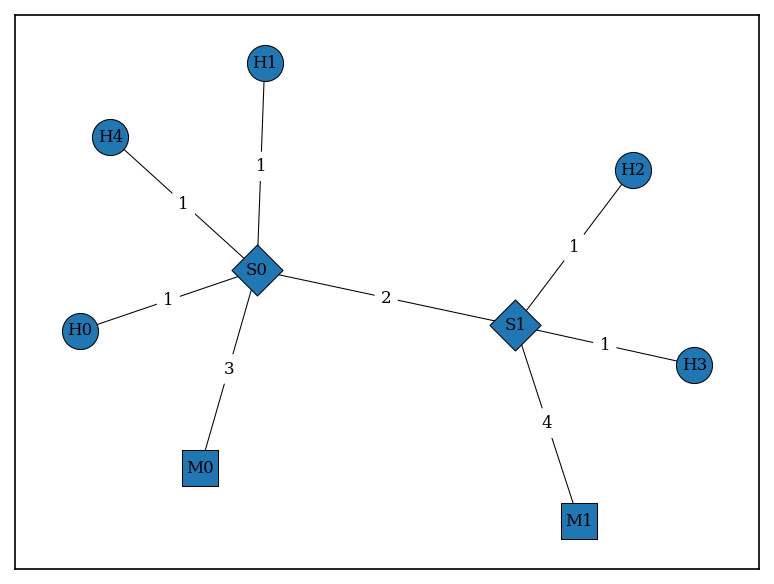

In [2]:
# Creating the undirected graph.
G = nx.Graph()

# Define and add nodes.
n_subscribers = 5
n_maholes = 2
n_splitters = 2

subscriber_nodes = [f"H{i}" for i in range(n_subscribers)]
manhole_nodes = [f"M{i}" for i in range(n_maholes)]
splitter_nodes = [f"S{i}" for i in range(n_splitters)]

G.add_nodes_from(subscriber_nodes) 
G.add_nodes_from(manhole_nodes) 
G.add_nodes_from(splitter_nodes) 
all_nodes = list(G.nodes())

# Define and add edges and their labels.
G.add_edge("S0", "H0", capacity=1)
G.add_edge("S0", "H1", capacity=1)
G.add_edge("S0", "H4", capacity=1)
G.add_edge("S0", "M0", capacity=3)
G.add_edge("S0", "S1", capacity=2)
G.add_edge("S1", "H2", capacity=1)
G.add_edge("S1", "H3", capacity=1)
G.add_edge("S1", "M1", capacity=4)
G_directed = G.to_directed()
weights = nx.get_edge_attributes(G_directed, 'capacity')

#Draw the graph
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, subscriber_nodes, node_shape='o', edgecolors="black", linewidths=0.5)
nx.draw_networkx_nodes(G, pos, manhole_nodes, node_shape='s', edgecolors="black", linewidths=0.5)
nx.draw_networkx_nodes(G, pos, splitter_nodes, node_shape='D', edgecolors="black", linewidths=0.5)
nx.draw_networkx_edges(G ,pos, width=0.5)
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, font_size=8, font_family="serif", rotate=False)
nx.draw_networkx_labels(G, pos, font_size=8, font_family="serif")
plt.show()

In [14]:
# Creating variables:
x = {}
for start in G_directed.edges():
    for end in G_directed.edges(start):
        if end[1] != start[0] and start[1] == end[0]:
            x[start, end] = \
            model.addVar(name=f"x[{start[0]} {start[1]} {end[1]}]", vtype=GRB.INTEGER)     
               
model.update()
if report: 
    for i, vars in enumerate(x.items()): 
        print(f"{i:2}:   {vars}")

 0:   ((('H0', 'S0'), ('S0', 'H1')), <gurobi.Var x[H0 S0 H1]>)
 1:   ((('H0', 'S0'), ('S0', 'H4')), <gurobi.Var x[H0 S0 H4]>)
 2:   ((('H0', 'S0'), ('S0', 'M0')), <gurobi.Var x[H0 S0 M0]>)
 3:   ((('H0', 'S0'), ('S0', 'S1')), <gurobi.Var x[H0 S0 S1]>)
 4:   ((('H1', 'S0'), ('S0', 'H0')), <gurobi.Var x[H1 S0 H0]>)
 5:   ((('H1', 'S0'), ('S0', 'H4')), <gurobi.Var x[H1 S0 H4]>)
 6:   ((('H1', 'S0'), ('S0', 'M0')), <gurobi.Var x[H1 S0 M0]>)
 7:   ((('H1', 'S0'), ('S0', 'S1')), <gurobi.Var x[H1 S0 S1]>)
 8:   ((('H2', 'S1'), ('S1', 'S0')), <gurobi.Var x[H2 S1 S0]>)
 9:   ((('H2', 'S1'), ('S1', 'H3')), <gurobi.Var x[H2 S1 H3]>)
10:   ((('H2', 'S1'), ('S1', 'M1')), <gurobi.Var x[H2 S1 M1]>)
11:   ((('H3', 'S1'), ('S1', 'S0')), <gurobi.Var x[H3 S1 S0]>)
12:   ((('H3', 'S1'), ('S1', 'H2')), <gurobi.Var x[H3 S1 H2]>)
13:   ((('H3', 'S1'), ('S1', 'M1')), <gurobi.Var x[H3 S1 M1]>)
14:   ((('H4', 'S0'), ('S0', 'H0')), <gurobi.Var x[H4 S0 H0]>)
15:   ((('H4', 'S0'), ('S0', 'H1')), <gurobi.Var x[H4 S

In [4]:
# Creating constraints for the start cable bundles:
for start in G_directed.edges():
    constr = 0
    for end in G_directed.edges(start):
        if (start, end) in x:
            var1 = x[start, end]
            constr = constr + var1
            model.addConstr(var1 >= 0)
            if ((end[1], end[0]),(start[1], start[0])) in x:
                var2 = x[(end[1], end[0]),(start[1], start[0])]
                constr = constr + var2
                model.addConstr(var2 >= 0)
  
    constr = constr == weights[start]
    if constr != False:
        if report: 
            print(constr)
        model.addConstr(constr)

<gurobi.TempConstr: x[H0 S0 H1] + x[H1 S0 H0] + x[H0 S0 H4] + x[H4 S0 H0] + x[H0 S0 M0] + x[M0 S0 H0] + x[H0 S0 S1] + x[S1 S0 H0] == 1>
<gurobi.TempConstr: x[H1 S0 H0] + x[H0 S0 H1] + x[H1 S0 H4] + x[H4 S0 H1] + x[H1 S0 M0] + x[M0 S0 H1] + x[H1 S0 S1] + x[S1 S0 H1] == 1>
<gurobi.TempConstr: x[H2 S1 S0] + x[S0 S1 H2] + x[H2 S1 H3] + x[H3 S1 H2] + x[H2 S1 M1] + x[M1 S1 H2] == 1>
<gurobi.TempConstr: x[H3 S1 S0] + x[S0 S1 H3] + x[H3 S1 H2] + x[H2 S1 H3] + x[H3 S1 M1] + x[M1 S1 H3] == 1>
<gurobi.TempConstr: x[H4 S0 H0] + x[H0 S0 H4] + x[H4 S0 H1] + x[H1 S0 H4] + x[H4 S0 M0] + x[M0 S0 H4] + x[H4 S0 S1] + x[S1 S0 H4] == 1>
<gurobi.TempConstr: x[M0 S0 H0] + x[H0 S0 M0] + x[M0 S0 H1] + x[H1 S0 M0] + x[M0 S0 H4] + x[H4 S0 M0] + x[M0 S0 S1] + x[S1 S0 M0] == 3>
<gurobi.TempConstr: x[M1 S1 S0] + x[S0 S1 M1] + x[M1 S1 H2] + x[H2 S1 M1] + x[M1 S1 H3] + x[H3 S1 M1] == 4>
<gurobi.TempConstr: x[S0 S1 H2] + x[H2 S1 S0] + x[S0 S1 H3] + x[H3 S1 S0] + x[S0 S1 M1] + x[M1 S1 S0] == 2>
<gurobi.TempConstr: x[S1

In [5]:
# Setting the objective function.
min = 0
for (start, end), var in x.items():
    if start[0] in subscriber_nodes and end[1] in subscriber_nodes:
        min += var
print(min)

x[H0 S0 H1] + x[H0 S0 H4] + x[H1 S0 H0] + x[H1 S0 H4] + x[H2 S1 H3] + x[H3 S1 H2] + x[H4 S0 H0] + x[H4 S0 H1]


In [6]:
def check_subscriber_path(x, subscriber_nodes):
    for (start, end), var in x.items():
        if var.xn != 0 and start[0] in subscriber_nodes and end[1] in subscriber_nodes:
            return True
    return False

In [13]:
# Setting the objective function
model.setObjective(min, sense = gp.GRB.MINIMIZE) 
model.setParam("OutputFlag", False)
model.setParam(GRB.Param.PoolSearchMode, 2) # Mode for searching all optimal solutions.
model.setParam(GRB.Param.PoolSolutions, 10000) # Number of solutions saved.
model.optimize()
model.write("DFG.lp")
no_solutions = model.SolCount
print_first = 2 # Number of solutions being printed.

# Printing the number of found solutions even non optimal.
print(f"Number of all solutions: {no_solutions}")

for i in range(print_first):
    model.setParam(GRB.Param.SolutionNumber, i)
    print(f"\nPrinting solution {i}: {model.PoolObjVal}")
    for var in model.getVars():
        if var.xn !=0:
            print(f"Variable {var.VarName}: {int(var.xn)}")

Number of all solutions: 1008

Printing solution 0: 0.0
Variable x[M0 S0 H1]: 1
Variable x[M0 S0 H4]: 1
Variable x[M1 S1 H2]: 1
Variable x[M1 S1 H3]: 1
Variable x[S0 S1 M1]: 2
Variable x[S1 S0 H0]: 1
Variable x[S1 S0 M0]: 1

Printing solution 1: 0.0
Variable x[H0 S0 S1]: 1
Variable x[H1 S0 M0]: 1
Variable x[H4 S0 M0]: 1
Variable x[M1 S1 H2]: 1
Variable x[M1 S1 H3]: 1
Variable x[S0 S1 M1]: 2
Variable x[S1 S0 M0]: 1


In [8]:
def darken_color(color, amount=0.8):
    rgb = mcolors.hex2color(color)
    hsv = mcolors.rgb_to_hsv(rgb)
    new_value = hsv[2] * amount
    new_rgb = mcolors.hsv_to_rgb((hsv[0], hsv[1], new_value))
    new_hex = mcolors.rgb2hex(new_rgb)
    return new_hex

In [9]:
def add_edge(G, a, b, c=0):
    if (a, b) in G.edges:
        max_rad = max(x[2]['rad'] for x in G.edges(data=True) if sorted(x[:2]) == sorted([a,b]))
    else:
        max_rad = 0
    G.add_edge(a, b, rad=max_rad+0.1, color=c)

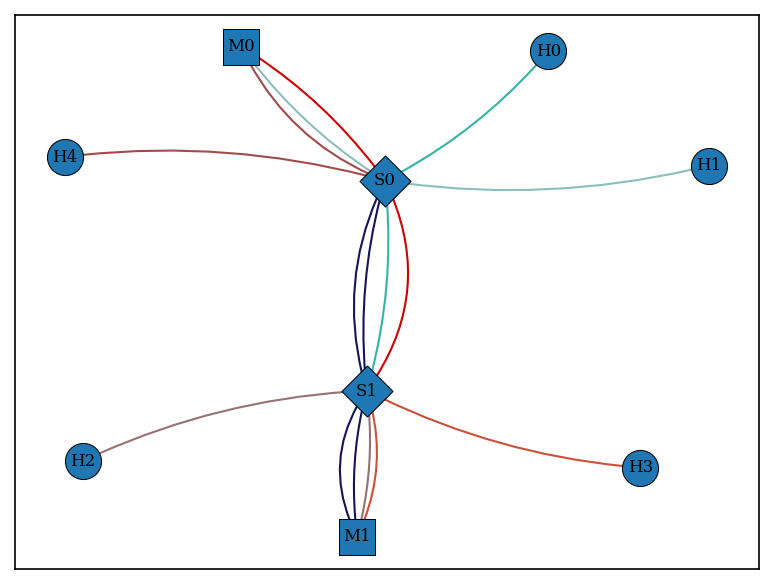

In [10]:
G_multi = nx.MultiDiGraph()

# Add nodes
G_multi.add_nodes_from(subscriber_nodes) 
G_multi.add_nodes_from(manhole_nodes) 
G_multi.add_nodes_from(splitter_nodes) 
model.setParam(GRB.Param.SolutionNumber, 0)
paths = []
for edge, var in x.items():
    if var.xn != 0:
        edges = [edge[0] for i in range(int(var.xn))]
        edges.extend([edge[1] for i in range(int(var.xn))])
        paths.append(edges)

num_colors = len(paths)
valid_colors = list(mcolors.CSS4_COLORS.values())  # List of valid color names
random.shuffle(valid_colors)
coloured_paths = [(path, darken_color(color)) for (path, color) in zip(paths, valid_colors[:num_colors]) if len(path) != 1]
for path, color in coloured_paths:
    for edge in path:
        add_edge(G_multi, edge[0], edge[1], color)

#Draw the graph 
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G_multi, pos, subscriber_nodes, node_shape='o', edgecolors="black", linewidths=0.5)
nx.draw_networkx_nodes(G_multi, pos, manhole_nodes, node_shape='s', edgecolors="black", linewidths=0.5)
nx.draw_networkx_nodes(G_multi, pos, splitter_nodes, node_shape='D', edgecolors="black", linewidths=0.5)
for edge in G_multi.edges(data=True):
    nx.draw_networkx_edges(G_multi, pos, edgelist=[(edge[0],edge[1])],connectionstyle=f'arc3, rad = {edge[2]["rad"]}', width=1.0, arrowstyle="-", edge_color=edge[2]["color"])
nx.draw_networkx_labels(G_multi, pos, font_size=8, font_family="serif")
plt.show()
